In [1]:
import hashlib
import pandas as pd
import pandahouse as ph
import scipy as sp
import seaborn as sns

# Соединение с ClickHouse
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20221220',
    'user':'student',
    'password':'dpo_python_2020'
}

# Запрос данных у ClickHouse
query = """
SELECT
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) BETWEEN '2022-11-25' AND '2022-12-01'
    AND exp_group in (2, 3)
GROUP BY exp_group, user_id
"""

# Выполнить запрос данных у ClickHouse
df = ph.read_clickhouse(query, connection=connection)
print(df)

# Оценить насколько похожи экспериментальные группы
df_count = df.groupby('exp_group').count()
print(df_count)

       exp_group  user_id  likes  views       ctr
0              3   115383     11     36  0.305556
1              3   123580     15     92  0.163043
2              2   131473     26    148  0.175676
3              2    23985     12     66  0.181818
4              2    24523     17    120  0.141667
...          ...      ...    ...    ...       ...
17044          3   122008      4     31  0.129032
17045          2    25383     16     57  0.280702
17046          3   122190     25     74  0.337838
17047          2   108927      8     33  0.242424
17048          2    17310      2     14  0.142857

[17049 rows x 5 columns]
           user_id  likes  views   ctr
exp_group                             
2             8480   8480   8480  8480
3             8569   8569   8569  8569


4664


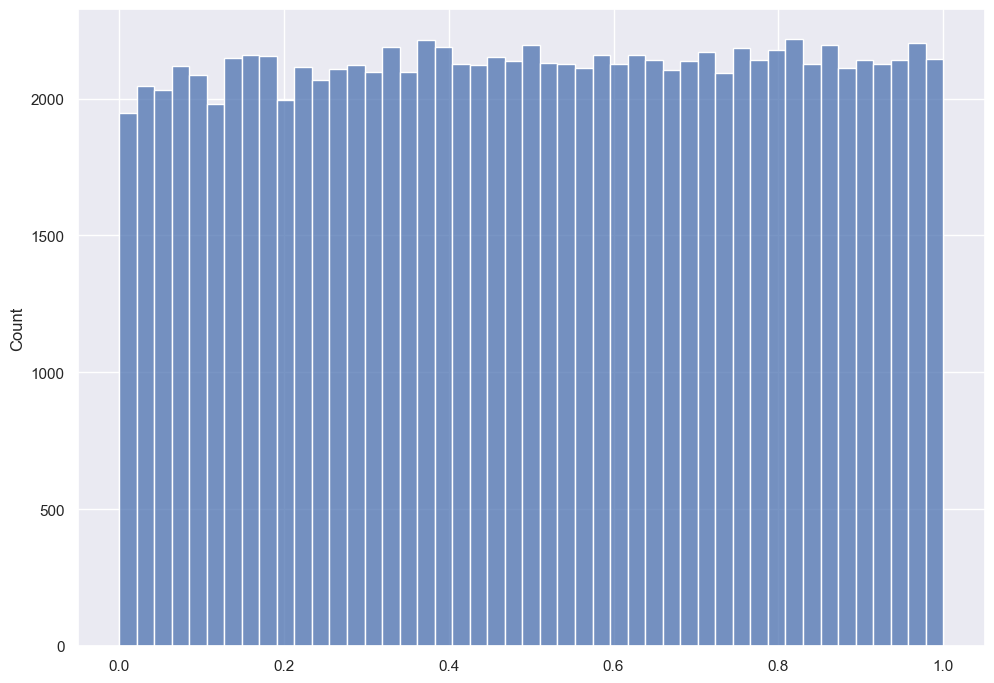

In [2]:
# n_exp: кол-во экспериментов
# n_obs: кол-во наблюдений в каждом эксперименте
# pvalues: массив p-значений
# pvalues_count: кол-во ложноположительных p-значений
n_exp = 100000
n_obs = 500
pvalues = []
pvalues_count = 0

# Провести эксперименты
for i in range(n_exp):
    # Получить выборки данных из каждой группы пользователей
    df2 = df[df.exp_group == 2].sample(n=n_obs, replace=False)
    df3 = df[df.exp_group == 3].sample(n=n_obs, replace=False)

    # Выполнить t-критерий Стьюдента
    ttest = sp.stats.ttest_ind(
        df2.ctr,
        df3.ctr,
        equal_var=False
    )
    
    # Получить значение t-критерия 
    pvalue = ttest[1]
    pvalues.append(pvalue)
    if pvalue <= 0.05:
        pvalues_count += 1

print(pvalues_count)

# Установка размера графика в seaborn
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Построение гистограммы
groups = sns.histplot(
    data = pvalues,
    kde=False
)


# Выводы
Цель нашего эксперимента заключалась в проверке корректности работы нашей системы сплитования, т.е. что изучаемая ключевая метрика (CTR) не отличается между группами пользователей.
Для этого мы многократно (100,000 раз) извлекли подвыборки из наших данных по 500 пользователей из 2 и 3 экспериментальных групп, а затем сравнили их с помощью t-test'ов.
Так как мы выбрали статистическую значимость на уровне 5%, следовательно при условии корректности нашей системы сплитования на группы около 5% t-test'ов должны показать статистически значимую разницу между подвыборками, то есть продемонстрировать ложно-положительный результат.
В результате эксперимента мы обнаружили что из 100,000 пар подвыборок 4,661 продемонстрировали статистически значимую разницу, то есть менее 5% пар подвыборок.
Следовательно мы можем сделать вывод что <b>наша система сплитования на группы является корректной</b>.